In [4]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *

from qiskit_aer import AerSimulator
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile,execute, Aer
from qiskit.visualization import *

from qiskit_aer import AerSimulator
import networkx as nx
from qiskit.algorithms.optimizers import COBYLA

from qiskit.utils import algorithm_globals


In [6]:
from qiskit import Aer
import networkx as nx
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit.circuit import QuantumCircuit, ParameterVector
import numpy as np
#from qiskit.optimization.applications.ising import tsp
from qiskit_optimization.applications import Tsp
#from qiskit.aqua.algorithms import NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.minimum_eigensolvers import QAOA , NumPyMinimumEigensolver
#from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
#from qiskit.optimization.problems import QuadraticProgram
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.primitives import Sampler
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit.quantum_info.operators import Operator # Generating a TSP instance of n cities
#
#YOU CAN IGNORE THE BELOW FUNCTIONS SINCE THEY ARE MADE FOR ANALYSIS PURPOSE
def interpret_tsp_all(counts, adj_matrix):
    total_counts = 0

    for meas, meas_count in counts.items():
        binary_list = list(map(int, meas))  # Convert '010101' to [0, 1, 0, 1, 0, 1]
        meas_arr = np.array(binary_list)
        
        try:
            tsp_interpretation = tsp.interpret(meas_arr)
            obj_for_meas = tsp.tsp_value(tsp_interpretation, adj_matrix)
            print(f"Measurement: {binary_list}, Count: {meas_count}, Objective Value: {obj_for_meas}")
            total_counts += meas_count
        except:
            pass

    return total_counts

from collections import Counter

def interpret_tsp(counts, adj_matrix):
    total_counts = 0
    objective_values = []

    for meas, meas_count in counts.items():
        binary_list = list(map(int, meas))  # Convert '010101' to [0, 1, 0, 1, 0, 1]
        meas_arr = np.array(binary_list)

        try:
            obj_for_meas = tsp.tsp_value(tsp.interpret(meas_arr), adj_matrix)
            if isinstance(obj_for_meas, np.ndarray) and obj_for_meas.size == 1:
                objective_values.append(obj_for_meas[0])
                print(f"Measurement: {binary_list}, Count: {meas_count}, Objective Value: {obj_for_meas[0]}")
            elif isinstance(obj_for_meas, np.ndarray) and obj_for_meas.size > 1:
                continue
            elif not obj_for_meas:
                continue
            else:
                objective_values.append(obj_for_meas)
                print(f"Measurement: {binary_list}, Count: {meas_count}, Objective Value: {obj_for_meas}")

            total_counts += meas_count
        except:
            pass

    objective_values_count = Counter(objective_values)

    print("\nObjective Value Summary:")
    for obj_val, count in objective_values_count.items():
        print(f"Objective Value: {obj_val}, Count: {count}")

    return total_counts
def analyze_counts(counts):
    highest_count = 0
    highest_outcome = None

    # Dictionary to store the count occurrences
    count_occurrences = {}

    for outcome, count in counts.items():
        if count > highest_count:
            highest_count = count
            highest_outcome = outcome
        
        # Update count occurrences
        if count in count_occurrences:
            count_occurrences[count].append(outcome)
        else:
            count_occurrences[count] = [outcome]

    print("Highest Count:", highest_count)
    print("Highest Outcome:", highest_outcome)

    # Find the lowest count and its corresponding outcome
    lowest_count = float('inf')
    lowest_outcome = None

    for outcome, count in counts.items():
        if count < lowest_count:
            lowest_count = count
            lowest_outcome = outcome

    print("Lowest Count:", lowest_count)
    print("Lowest Outcome:", lowest_outcome)

    # Show count occurrences
    print("Count Occurrences:")
    for count, outcomes in count_occurrences.items():
        print("Count:", count)
        print("Occurrences:", len(outcomes))
        print("Outcomes:", outcomes)
        print()

def correct_dict_all(counts, adj_matrix):
    result_dict = {}

    for meas, meas_count in counts.items():
        binary_list = list(map(int, meas))  # Convert '010101' to [0, 1, 0, 1, 0, 1]
        meas_arr = np.array(binary_list)
        
        try:
            tsp_interpretation = tsp.interpret(meas_arr)
            obj_for_meas = tsp.tsp_value(tsp_interpretation, adj_matrix)
            result_dict[''.join(map(str, binary_list))] = meas_count
            
        except:
            pass

    return result_dict


def correct_dict(counts, adj_matrix):
    result_dict = {}

    for meas, meas_count in counts.items():
        binary_list = list(map(int, meas))  # Convert '010101' to [0, 1, 0, 1, 0, 1]
        meas_arr = np.array(binary_list)

        try:
            obj_for_meas = tsp.tsp_value(tsp.interpret(meas_arr), adj_matrix)
            if isinstance(obj_for_meas, np.ndarray) and obj_for_meas.size == 1:
                objective_value = obj_for_meas[0]
            elif isinstance(obj_for_meas, np.ndarray) and obj_for_meas.size > 1:
                continue
            elif not obj_for_meas:
                continue
            else:
                objective_value = obj_for_meas

            result_dict[''.join(map(str, binary_list))] = meas_count
        except:
            pass

    return result_dict


In [7]:
import itertools
#THE BELOW FUNCTION CALCULATES TSP CLASSICALLY

def tsp_brute_force(distances):
    num_cities = len(distances)
    all_cities = set(range(num_cities))
    shortest_path = None
    shortest_distance = float('inf')

    for permutation in itertools.permutations(all_cities):
        distance = 0
        for i in range(num_cities - 1):
            current_city = permutation[i]
            next_city = permutation[i + 1]
            distance += distances[current_city][next_city]

        # Add the last leg of the path to complete the cycle
        distance += distances[permutation[-1]][permutation[0]]

        if distance < shortest_distance:
            shortest_distance = distance
            shortest_path = permutation

    return  shortest_distance #,shortest_path

In [8]:
#THIS PART CREATES AN INSTANCE OF TSP THEN IT CONVERTS THAT INTO PAULI OPERATOR LIST(IN SHORT THIS WHERE ENCODING PART IS DONE)
n = 3
num_qubits = n ** 2
tsp =Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

# Create a random TSP Hamiltonian
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print(qubitOp, offset)

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]
Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2

-1282.5 * IIIIIIIIZ
- 1282.5 * IIIIIIIZI
- 1282.5 * IIIIIIZII
- 1268.5 * IIIIIZIII
- 1268.5 * IIIIZIIII
- 1268.5 * IIIZIIIII
- 1290.0 * IIZIIIIII
- 1290.0 * IZIIIIIII
- 1290.0 * ZIIIIIIII
+ 606.5 * IIIIIIIZZ
+ 606.5 * IIIIIIZIZ
+ 606.5 * IIIIIIZZI
+ 606.5 * II

In [9]:
def getckt(qubitOp, theta, reps):
    circuit = QAOAAnsatz( cost_operator=qubitOp, reps=reps)  #CREATES STANDARD QAOA CIRCUIT
    circuit =circuit.decompose( reps=3) # DECOMPOSES FOR VISUALIZATION PURPOSES
    bind_dict = {}                      # THESE LINES ASSIGNS THE PARAMETERS OF BETA AND GAMMA TO THE QAOA CIRCUIT
    param =theta
    for i, key in enumerate(circuit.parameters):
        bind_dict[key] = param[i]

        
    circuit = circuit.bind_parameters(bind_dict)
    
    for i in range(num_qubits - 1):      # THE BELOW LINES CONSTRUCTS THE PROBLEM INDEPENDENT LAYER WITH RANDOM PARAMETERS 
    
        random_param = np.random.uniform(low=-(0.01*np.pi), high=0.01*np.pi)
        circuit.crz(random_param, i, i+1)
        circuit.x(range(num_qubits))
    
    circuit.measure_all()
    return circuit

#NOTE THAT BETA AND GAMMA PARAMETERS ARE DEPENDENT ON P SO IF P = 1 THE THE PARAMS WOULD BE 2P ONE FOR BETA NAD ONE FOR GAMMA 
#BUT IN THE CASE OF PROBLEM INDEPENDENT LAYER IT DEPENDS ON THE NUMBER OF QUBIT HENCE IT IS CALLED A MULTIPARAMETER LAYER

'''circuit.barrier()
# Apply CRZ gates iteratively between adjacent qubits with random parameters
for i in range(num_qubits - 1):
    random_param = np.random.uniform(low=-(0.01*np.pi), high=0.01*np.pi)
    circuit.crz(random_param, i, i+1)

circuit.barrier()
# Apply X gates to all qubits
circuit.x(range(num_qubits))'''

# IGNORE THE BELOW BIND PART 

'''p =1
alpha = ParameterVector('α', length=(1))
circuit.barrier()
for i in range(num_qubits - 1):
    circuit.crz(alpha[0], i, i+1)

        

# Apply X gates to all qubits

circuit.x(range(num_qubits))
circuit.bind_parameters({alpha[0] : 1}).draw()'''

"p =1\nalpha = ParameterVector('α', length=(1))\ncircuit.barrier()\nfor i in range(num_qubits - 1):\n    circuit.crz(alpha[0], i, i+1)\n\n        \n\n# Apply X gates to all qubits\n\ncircuit.x(range(num_qubits))\ncircuit.bind_parameters({alpha[0] : 1}).draw()"

In [10]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()} #MSB most significant bit

In [11]:
#print("result: ", result)
'''
quasi_dists = {}
for key,count in counts.items():
    quasi_dists[key] = count/1024
#print("counts: ", counts)
print("quasi_dists: ", quasi_dists)
plot_histogram(quasi_dists)'''

'\nquasi_dists = {}\nfor key,count in counts.items():\n    quasi_dists[key] = count/1024\n#print("counts: ", counts)\nprint("quasi_dists: ", quasi_dists)\nplot_histogram(quasi_dists)'

In [12]:
'''from qiskit.circuit import ParameterVector, QuantumCircuit

# define your parameters
p = ParameterVector('p', 1)  

circuit = QuantumCircuit(2)
circuit.rx(p[0], 0)  # RX(p[0]) on qubit 0
circuit.ry(p[0], 0)  # RY(p[1]) on qubit 1
circuit.crz(p[0], 0, 1)  # CRZ(p[2]) controlled on qubit 0, acting on qubit 1

# bind the values
bound_circuit = circuit.bind_parameters({p: [0]})
bound_circuit.draw()'''


"from qiskit.circuit import ParameterVector, QuantumCircuit\n\n# define your parameters\np = ParameterVector('p', 1)  \n\ncircuit = QuantumCircuit(2)\ncircuit.rx(p[0], 0)  # RX(p[0]) on qubit 0\ncircuit.ry(p[0], 0)  # RY(p[1]) on qubit 1\ncircuit.crz(p[0], 0, 1)  # CRZ(p[2]) controlled on qubit 0, acting on qubit 1\n\n# bind the values\nbound_circuit = circuit.bind_parameters({p: [0]})\nbound_circuit.draw()"

In [13]:
'''def compute_tsp_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        binary_list = [int(bit) for bit in meas]
        meas_arr = np.array(binary_list)
        obj_for_meas = tsp.tsp_value(tsp.interpret(meas_arr),adj_matrix)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_tsp_energy(invert_counts(result.get_counts()), adj_matrix)'''

'def compute_tsp_energy(counts, G):\n    energy = 0\n    total_counts = 0\n    for meas, meas_count in counts.items():\n        binary_list = [int(bit) for bit in meas]\n        meas_arr = np.array(binary_list)\n        obj_for_meas = tsp.tsp_value(tsp.interpret(meas_arr),adj_matrix)\n        energy += obj_for_meas * meas_count\n        total_counts += meas_count\n    return energy / total_counts\n\ncompute_tsp_energy(invert_counts(result.get_counts()), adj_matrix)'

In [14]:


# Example usage

  # Example adjacency matrix

'''interpret_tsp_all(counts, adj_matrix)'''


'interpret_tsp_all(counts, adj_matrix)'

In [15]:


# Example usage

 # Example adjacency matrix

'''interpret_tsp(counts, adj_matrix)'''


'interpret_tsp(counts, adj_matrix)'

In [16]:
from collections import defaultdict



'''c0 = correct_dict(counts, adj_matrix)
print(c0)
quasi_dists = {}
for key,count in c0.items():
    quasi_dists[key] = count/1024
#print("counts: ", counts)
print("quasi_dists: ", quasi_dists)
plot_histogram(quasi_dists)'''

'c0 = correct_dict(counts, adj_matrix)\nprint(c0)\nquasi_dists = {}\nfor key,count in c0.items():\n    quasi_dists[key] = count/1024\n#print("counts: ", counts)\nprint("quasi_dists: ", quasi_dists)\nplot_histogram(quasi_dists)'

In [17]:
def tsp_obj( result, adj_matrix: np.ndarray) -> float:
    x = result
    n = int(np.sqrt(len(x)))
    total_cost = 0.0

    for p__ in range(n):
        for i in range(n):
            if x[i * n + p__]:
                total_cost += adj_matrix[i, p__]

    return total_cost
# result = 01010101 , adj_matrix = distance matrix

In [18]:
'''c1 = correct_dict(counts, adj_matrix)
plot_histogram(c1 )'''

'c1 = correct_dict(counts, adj_matrix)\nplot_histogram(c1 )'

In [19]:
'''def compute_tsp_energy(counts, G):
    energy = 0
    total_counts = 0
    counts =  correct_dict(counts, adj_matrix)
    
    for meas, meas_count in counts.items():
        binary_list = [int(bit) for bit in meas]
        meas_arr = np.array(binary_list)
        obj_for_meas = tsp.tsp_value(tsp.interpret(meas_arr),adj_matrix)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy '''
def compute_tsp_energy(counts, distances):
    energy = 0
    total_counts = 0
    #counts =  correct_dict(counts, adj_matrix)
    
    for meas, meas_count in counts.items():
        binary_list = [int(bit) for bit in meas]
        meas_arr = np.array(binary_list)
        obj_for_meas = tsp_obj(meas_arr,adj_matrix)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return (energy /total_counts)
    

#compute_tsp_energy(invert_counts(counts), adj_matrix)

In [20]:
def get_black_box_objective(adj_matrix,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        circuit = getckt(qubitOp, theta , reps= 1)
        counts = execute(circuit, backend, seed_simulator=10,shots = 5048).result().get_counts()
        
        # return the energy
        return -compute_tsp_energy(invert_counts(counts), adj_matrix)
    return f


In [25]:
from scipy.optimize import minimize
# p is the number of QAOA alternating operators
p = 1
obj = get_black_box_objective(adj_matrix, p=1)

init_point = np.array([1,-1])
# We are going to limit the number of iterations to 2500

res_sample = minimize(obj, init_point, method='Nelder-Mead', options={'maxiter':2500, 'disp': True})
res_sample

methods = [‘Nelder-Mead’, ‘Powell’, ‘CG’, ‘BFGS’

‘Newton-CG’

‘L-BFGS-B’

‘TNC’

‘COBYLA’

‘SLSQP’

‘trust-constr’

‘dogleg’

‘trust-ncg’

‘trust-exact’

‘trust-krylov’]


Optimization terminated successfully.
         Current function value: -226.151941
         Iterations: 43
         Function evaluations: 103


 final_simplex: (array([[ 0.97661511, -1.01251465],
       [ 0.97661188, -1.01251466],
       [ 0.97661413, -1.01251466]]), array([-226.15194136, -226.15194136, -226.15194136]))
           fun: -226.151941362916
       message: 'Optimization terminated successfully.'
          nfev: 103
           nit: 43
        status: 0
       success: True
             x: array([ 0.97661511, -1.01251465])

In [ ]:
#import spsa
#sps = spsa.minimize(obj, init_point)

In [202]:
optimal_theta = res_sample['x']
backend = Aer.get_backend('qasm_simulator')
qc = getckt(qubitOp, optimal_theta, reps= 1)
counts = invert_counts(execute(qc, backend).result().get_counts())
counts


{'100000111': 1,
 '111000110': 1,
 '001010111': 1,
 '010011011': 1,
 '101011101': 2,
 '010110111': 1,
 '101011001': 1,
 '101010001': 1,
 '111100011': 1,
 '000111011': 1,
 '010101011': 1,
 '100110010': 1,
 '011000100': 1,
 '110101110': 3,
 '110011100': 1,
 '101101100': 1,
 '100100110': 1,
 '111110010': 2,
 '101100111': 1,
 '111010011': 3,
 '010000110': 1,
 '011110110': 2,
 '011100110': 2,
 '100010101': 1,
 '100100100': 1,
 '000010111': 1,
 '110101101': 4,
 '001100110': 2,
 '110011110': 3,
 '101110001': 4,
 '011110111': 8,
 '011010111': 1,
 '111100111': 2,
 '111111100': 16,
 '011101110': 4,
 '111111011': 72,
 '110110111': 4,
 '111111010': 15,
 '111011011': 6,
 '011101101': 2,
 '000111000': 1,
 '011111011': 12,
 '101110111': 7,
 '010100101': 1,
 '011110011': 5,
 '111101100': 5,
 '011001011': 1,
 '101111101': 8,
 '110111100': 1,
 '010111110': 1,
 '111110101': 3,
 '011100111': 2,
 '111111000': 8,
 '011101111': 13,
 '010111111': 3,
 '001001011': 1,
 '011011101': 1,
 '011111111': 39,
 '101111

In [203]:
obtained_cost =compute_tsp_energy(counts, adj_matrix)
correct_cost = tsp_brute_force(adj_matrix)
approximation_ratio = obtained_cost/correct_cost
error = ((obtained_cost-correct_cost)/correct_cost)*100
print('obtained_cost',obtained_cost)
print('correct_cost',correct_cost)

print('approximation_ratio',approximation_ratio)
print('error %',abs(error))


obtained_cost 329.1259765625
correct_cost 202.0
approximation_ratio 1.6293365176361385
error % 62.93365176361386


(154.0, 293.0, 245.0, 174.0, 250.0, 91.0, 222.0, 111.0, 230.0, 313.0, 202.0, 341.0, 139.0, 265.0, 404.0, 187.0, 278.0, 217.0, 356.0, 308.0, 159.0, 126.0, 182.0) (10, 44, 13, 8, 62, 3, 3, 4, 5, 165, 34, 133, 7, 41, 347, 4, 6, 27, 76, 25, 2, 3, 2)
329.1259765625


<BarContainer object of 23 artists>

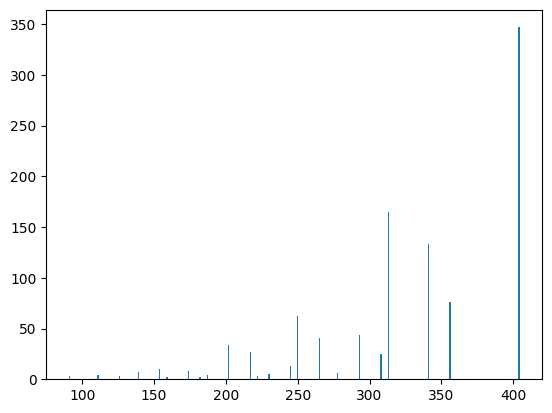

In [204]:
import matplotlib.pyplot as plt
energies = defaultdict(int)
for k, v in counts.items():
    binary_list = [int(bit) for bit in k]
    k = np.array(binary_list)
    
    
    try:
        energies[tsp_obj(k,adj_matrix)] += v#energies[tsp.tsp_value(tsp.interpret(k),adj_matrix)] += v
        
        
        #print(tsp.tsp_value(tsp.interpret(k),adj_matrix))
    except:
        pass

x,y = zip(*energies.items())



print(x,y)
print(compute_tsp_energy(counts, adj_matrix))
plt.bar(x,y)

150
341.0


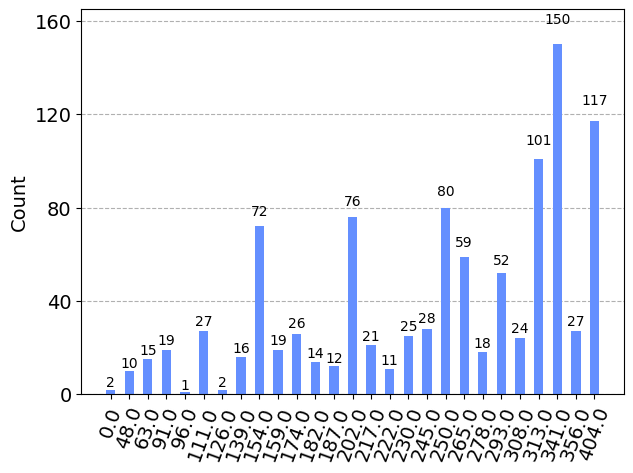

In [170]:
keys = x
values = y

tuple_list = list(zip(keys, values))
dictionary = dict(tuple_list)
my_dict = dictionary

sorted_dict = dict(sorted(my_dict.items(), key=lambda x: x[0]))

print(max(dictionary.values()))
max_key = max(my_dict, key=my_dict.get)

print(max_key)
plot_histogram(dictionary)

In [56]:
from operator import itemgetter
best_cut = max([(tsp_obj(x,adj_matrix),x) for x in counts.keys()])
print(best_cut)
from operator import itemgetter

# Assuming counts is a dictionary where the keys represent paths and the values represent their respective counts
# Assuming adj_matrix is the adjacency matrix for the TSP problem

# Calculate the objective function values for each path in counts
objective_values = [(tsp_obj(x, adj_matrix), x) for x in counts.keys()]

# Sort the list of tuples based on the objective function values
sorted_values = sorted(objective_values, key=itemgetter(0))

# Get the middle element
middle_val = sorted_values[len(sorted_values) // 2]

print("Middle value:", middle_val)


(404.0, '111111111')
Middle value: (404.0, '001000101')


(202.0, 174.0, 139.0, 187.0, 96.0, 182.0, 154.0, 250.0, 341.0, 265.0, 230.0, 308.0, 293.0, 245.0, 313.0, 356.0, 159.0, 278.0, 111.0, 48.0, 404.0, 91.0, 217.0, 126.0, 222.0, 63.0, 0.0) (493, 78, 243, 71, 58, 39, 642, 143, 68, 229, 59, 70, 225, 124, 96, 68, 67, 31, 180, 363, 48, 364, 213, 50, 29, 356, 641)
433


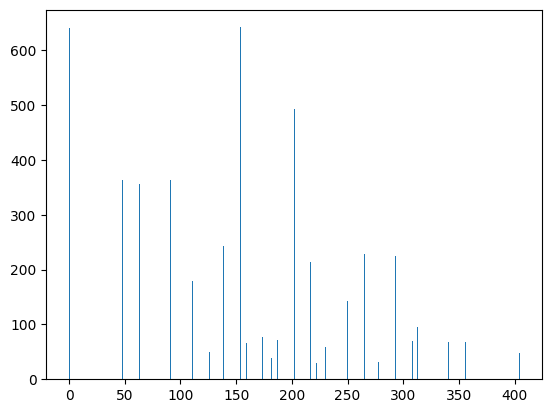

In [50]:
theta = [0.81, 2.201]
backend = Aer.get_backend('qasm_simulator')
qc = getckt(qubitOp, theta , reps= 1)
counts = execute(qc,backend, seed_simulator=10,shots = 5048).result().get_counts()
#print(interpret_tsp_all(count,adj_matrix))
import matplotlib.pyplot as plt
energies = defaultdict(int)
for k, v in counts.items():
    binary_list = [int(bit) for bit in k]
    k = np.array(binary_list)
    
    
    try:
        energies[tsp_obj(k,adj_matrix)] += v#energies[tsp.tsp_value(tsp.interpret(k),adj_matrix)] += v
        
        
        #print(tsp.tsp_value(tsp.interpret(k),adj_matrix))
    except:
        pass

x,y = zip(*energies.items())
plt.bar(x,y)
print(x,y)
print(len(counts))

In [57]:

compute_tsp_energy(counts, adj_matrix,offset = 0)


203.32824881141045

In [46]:
import numpy as np

def calculate_tsp_expected_energy(counts, distance_matrix):
    total_energy = 0.0
    total_counts = sum(counts.values())
    
    for path, count in counts.items():
        energy = 0.0
        binary_path = [int(bit) for bit in path]  # Convert binary path to a list of integers
        for i in range(len(binary_path)):
            j = (i +1) % len(binary_path)
            energy += distance_matrix[binary_path[i]][binary_path[j]]
        total_energy += energy * (count / total_counts)
    
    return total_energy
calculate_tsp_expected_energy(counts,adj_matrix)

214.45958795562538

In [39]:
print(res_sample['fun'])

-7377.300316957211


In [ ]:
print(tsp.interpret(np.array([0,0,1,1,0,0,0,1,0])))